In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## PolyA gene transcript detection

What fraction of polyA genes from the annotation do we detect with at least 1 known isoform >= 1 TPM in any library?

In [3]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


In [3]:
# merge with gene id
gene_df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

In [4]:
gene_df, _, _ = get_gtf_info(how='gene')

polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
polya_genes = gene_df.loc[gene_df.biotype_category.isin(polya_biotypes), 'gid'].tolist()
n_polya = len(polya_genes)
n_det_polya = len(df.annot_gene_id.unique().tolist())

print('Detected {} / {} annotated polyA genes w/ at least 1 known transcript >= 1 TPM'.format(n_det_polya, n_polya))

Detected 24936 / 49472 annotated polyA genes w/ at least 1 known transcript >= 1 TPM


## Protein coding gene transcript detection

What fraction of protein-coding genes do we detect with at least 1 known isoform >= 1 TPM in any library?

In [26]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
# no gene subset here so we can look at all other genes
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1)

Calculating iso TPM values
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Number of isos reported: 77128


In [27]:
# merge with gene id
gene_df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

In [28]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene')
df = df.merge(gene_df, how='left', left_on='annot_gene_id', right_on='gid')

In [29]:
df.head()

,gm12878_1_1,gm12878_1_2,gm12878_1_3,gm12878_1_4,gm12878_3_1,gm12878_2_1,gm12878_2_2,pgp1_1_1,pgp1_1_2,h9_1_1,...,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1,annot_gene_id,annot_transcript_id,gid,length,biotype,biotype_category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,ENSG00000243485.5,ENST00000469289.1,ENSG00000243485.5,1555,lincRNA,lncRNA
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.737626,1.618796,0.000000,...,0.0,0.0,0.0,0.0,ENSG00000237613.2,ENST00000417324.1,ENSG00000237613.2,1527,lincRNA,lncRNA
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.737626,0.000000,0.000000,...,0.0,0.0,0.0,0.0,ENSG00000237613.2,ENST00000461467.1,ENSG00000237613.2,1527,lincRNA,lncRNA
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,ENSG00000233750.3,ENST00000442987.3,ENSG00000233750.3,3811,processed_pseudogene,pseudogene
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.737626,6.475185,1.242064,...,0.0,0.0,0.0,0.0,ENSG00000268903.1,ENST00000494149.2,ENSG00000268903.1,754,processed_pseudogene,pseudogene


In [30]:
temp = df[['gid', 'biotype_category']].drop_duplicates().groupby('biotype_category').count()
temp.reset_index(inplace=True)
temp.rename({'gid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_cat_counts, on='biotype_category', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)
temp

,biotype_category,detected_counts,gencode_counts,prop_detected
3,protein_coding,17052,19969,0.853924
0,lncRNA,4777,15006,0.318339
2,other,1908,7426,0.256935
1,miRNA,418,1881,0.222222
4,pseudogene,3107,14497,0.214320


## What fraction of protein coding gene transcripts do we detect?

Of the transcripts associated with protein coding genes GENCODE, how many do we detect >=1 1 TPM?

In [31]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


In [32]:
t_df, b_counts, b_cat_counts = get_gtf_info(how='iso')
df = df.merge(t_df, how='left', left_index=True, right_on='tid')

In [34]:
temp = df[['tid', 'biotype_category']].groupby('biotype_category').count()
temp.reset_index(inplace=True)
temp.rename({'tid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_cat_counts, on='biotype_category', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)
temp

,biotype_category,detected_counts,gencode_counts,prop_detected
1,protein_coding,64084.0,151259,0.423671
0,lncRNA,7073.0,28478,0.248367
2,pseudogene,3639.0,17657,0.206094
3,miRNA,NaN,1881,NaN
4,other,NaN,7486,NaN


## Characteristics of detected known, polyA gene associated transcripts

## Number of cell types or tissues that each known transcript from polyA genes is expressed >= 1 TPM

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796
Found 31 total samples


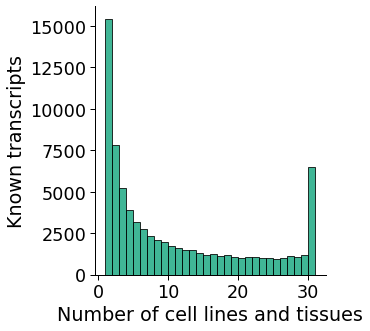

In [2]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = plot_biosamp_det(df,
                      how='iso',
                      min_tpm=1,
                      gene_subset='polya',
                      sample=None,
                      groupby='sample',
                      nov='Known',
                      opref='figures/human')

In [9]:
specific_thresh = 4
ubiq_thresh = 20

n_iso = len(df.index)
n_specific = len(df.loc[df.n_samples <= specific_thresh].index)
n_ubiq = len(df.loc[df.n_samples >= ubiq_thresh].index)

print('{} / {} ({:.1f}%) transcripts are expressed in <= {} samples'.format(n_specific, n_iso, (n_specific/n_iso)*100, specific_thresh))
print('{} / {} ({:.1f}%) transcripts are expressed in >= {} samples'.format(n_ubiq, n_iso, (n_ubiq/n_iso)*100, ubiq_thresh))

32327 / 74796 (43.2%) transcripts are expressed in <= 4 samples
16872 / 74796 (22.6%) transcripts are expressed in >= 20 samples


## Length of transcripts from polyA genes detected >= 1 TPM

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


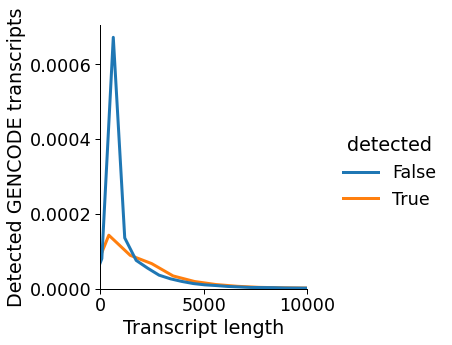

In [2]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = plot_det_len_kde(df, 
                      how='iso', 
                      subset='polya',
                      min_tpm=1,
                      xlim=10000,
                      opref='figures/')

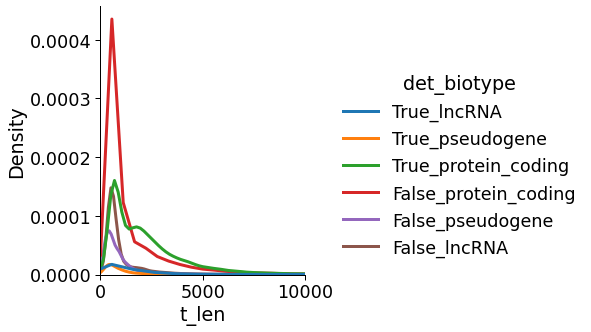

In [9]:
df['det_biotype'] = df.detected.astype('str')+'_'+df.biotype_category
ax = sns.displot(data=df, x='t_len', kind='kde',
                     linewidth=3, hue='det_biotype', common_norm=True)
ax.set(xlim=(0,10000))

What is the longest detected transcript with more than one exon?

In [7]:
t_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
t_df = t_df[['annot_transcript_id', 'n_exons']]

In [9]:
df = df.merge(t_df, how='left', on='annot_transcript_id')

In [10]:
n = df.loc[(df.detected == True)&(df.n_exons > 1), 't_len'].max()
print(n)

37852


In [11]:
df.loc[df.t_len == 37852]

,annot_transcript_id,tid,t_len,gid,biotype,biotype_category,detected,n_exons
70907,ENST00000458178.2,ENST00000458178.2,37852,ENSG00000224086.5,antisense,lncRNA,True,2.0


## Variance in TPM levels >= 1 TPM for known transcripts detected >= 1 TPM

In [41]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


## How many known polyA transcripts do we detect?

In [7]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


In [8]:
# merge with transcript len
t_df, b_counts, c_counts = get_gtf_info(how='iso')
df = df.merge(t_df, how='left', left_index=True, right_on='tid')

In [17]:
polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
n_det_polya = len(df.index)
n_known_polya = c_counts.loc[c_counts.biotype_category.isin(polya_biotypes), 'gencode_counts'].sum()
print('Detected {} / {} annotated transcripts from polyA genes >= 1 TPM'.format(n_det_polya, n_known_polya))

Detected 74796 / 197394 annotated transcripts from polyA genes >= 1 TPM


## How many complete isoforms do we detect?

In [2]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known', 'NIC', 'NNC'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on polya genes
Number of isos reported: 98027


  transcript_novelty  counts
0              Known   73961
1                NIC   18270
2                NNC    5796
Number of complete isoforms: 98027


<Figure size 288x432 with 0 Axes>

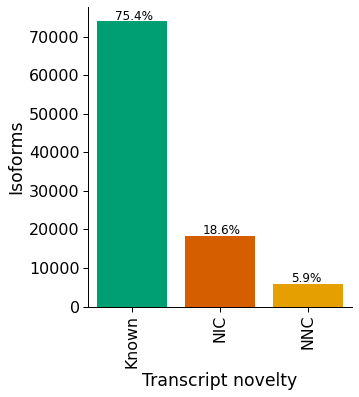

<Figure size 432x288 with 0 Axes>

In [3]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_transcript_novelty(df,
                        oprefix='figures/complete_det',
                        whitelist=tids,
                        novs=['Known', 'NIC', 'NNC'])

## How many exons are in each complete, detected model, split by novelty?

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on polya genes
Number of isos reported: 98027


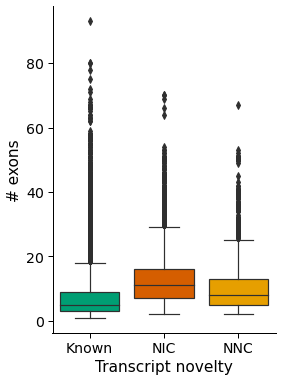

In [2]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_exons_per_iso(df,
                   nov=['Known', 'NIC', 'NNC'],
                   min_tpm=1,
                   gene_subset='polya',
                   opref='figures/human')

## How many isoforms per gene do we detect per sample? 

What is the average and range of complete isoforms per polyA gene that we detect per sample?

In [2]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on polya genes
Number of isos reported: 98027
Found 31 total samples


In [4]:
print('Average # isoforms / gene / sample: {}'.format(df.mean().mean())

1.4253880911531187

In [5]:
print('Max # isoforms / gene / sample: {}'.format(df.max().max())

134

Which samples have the highest average?

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on polya genes
Number of isos reported: 98027
Found 31 total samples


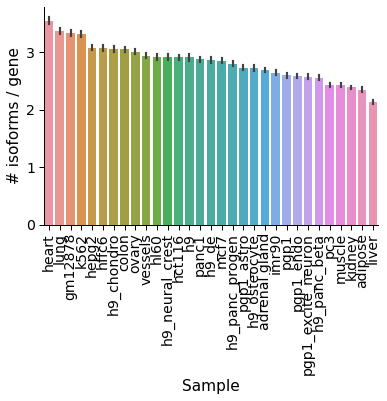

In [4]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_avg_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       sample='all', 
                       groupby='sample',
                       nov=['Known', 'NIC', 'NNC'],
                       opref='figures/human')

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [ ]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
reads = get_reads_per_sample(df, groupby='sample')

In [ ]:
reads.head()

In [34]:
tissue_df = get_tissue_metadata()

In [36]:
tissue_df.loc[tissue_df.tissue == 'adipose']

,biosample_name,tissue,biosample
0,subcutaneous adipose tissue,adipose,subcutaneous_adipose_tissue
7,omental fat pad,adipose,omental_fat_pad
21,mesenteric fat pad,adipose,mesenteric_fat_pad
55,adipose tissue,adipose,adipose_tissue


In [37]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
dataset_cols = get_dataset_cols()
cols = ['annot_transcript_id']+dataset_cols
df = df[cols]
df.set_index('annot_transcript_id', inplace=True)
df = df.transpose()
df.index.name = 'dataset'
df.reset_index(inplace=True)

In [38]:
df.head()

annot_transcript_id,dataset,ENST00000469289.1,ENST00000417324.1,ENST00000461467.1,ENST00000442987.3,ENST00000494149.2,ENST00000410691.1,ENST00000623083.4,ENST00000635159.1,ENST00000614007.1,...,ENCODEHT003677551,ENCODEHT003677552,ENCODEHT003677553,ENCODEHT003677554,ENCODEHT003677555,ENCODEHT003677556,ENCODEHT003677557,ENCODEHT003677558,ENCODEHT003677559,ENCODEHT003677560
0,gm12878_1_1,0,0,0,0,0,0,11,0,0,...,0,0,0,0,0,0,0,0,0,0
1,gm12878_1_2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,gm12878_1_3,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,gm12878_1_4,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,gm12878_3_1,0,0,0,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df.columns.name = ''
df.head()

,dataset,ENST00000469289.1,ENST00000417324.1,ENST00000461467.1,ENST00000442987.3,ENST00000494149.2,ENST00000410691.1,ENST00000623083.4,ENST00000635159.1,ENST00000614007.1,...,ENCODEHT003677551,ENCODEHT003677552,ENCODEHT003677553,ENCODEHT003677554,ENCODEHT003677555,ENCODEHT003677556,ENCODEHT003677557,ENCODEHT003677558,ENCODEHT003677559,ENCODEHT003677560
0,gm12878_1_1,0,0,0,0,0,0,11,0,0,...,0,0,0,0,0,0,0,0,0,0
1,gm12878_1_2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,gm12878_1_3,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,gm12878_1_4,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,gm12878_3_1,0,0,0,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
datasets = df.dataset.tolist()
df = df.sum(axis=1).to_frame()
df['dataset'] = datasets
df.rename({0: 'n_reads'}, axis=1, inplace=True)

In [53]:
df.loc[df.dataset == 'mesenteric_fat_pad_1_1']

,n_reads,dataset
71,1794731,mesenteric_fat_pad_1_1


In [54]:
# add biosample name (ie without rep information)
df['biosample'] = df.dataset.str.rsplit('_', n=2, expand=True)[0]
df.drop(['dataset'], axis=1, inplace=True)

# record the highest TPM value per biosample
tissue_df = get_tissue_metadata()
tissue_df = tissue_df[['tissue', 'biosample']]

df = df.merge(tissue_df, how='left', on='biosample')
df.loc[df.tissue.isnull(), 'tissue'] = df.loc[df.tissue.isnull(), 'biosample']
df.drop('biosample', axis=1, inplace=True)
df.rename({'tissue': 'biosample'}, axis=1, inplace=True)

print('Found {} total samples'.format(len(df.biosample.unique().tolist())))

Found 31 total samples


,n_reads
biosample,
adipose,1794731
adrenal gland,2922026
colon,2909348
gm12878,8457358
h9,5934779
h9_chondro,3742147
h9_de,4793127
h9_neural_crest,2002156
h9_osteocyte,3627588


In [31]:
df.sum(axis=1).head()

0     715140
1     605674
2     537713
3     656794
4    1487483
dtype: int64

Number of libraries per sample vs. # isos / gene

In [ ]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])
df.head()

In [32]:
n_libs = get_n_libs_per_sample()

In [33]:
n_libs.head()

,biosample,n_libraries
0,adipose,1
1,adrenal gland,3
2,colon,3
3,gm12878,7
4,h9,2


In [17]:
# remove 0s as they aren't really relevant
df = df.melt()
df.rename({'variable': 'biosample',
           'value': 'n_isos'}, axis=1, inplace=True) 
df = df.loc[df.n_isos != 0]


In [18]:
df = df.merge(n_libs, how='left', on='biosample')

In [22]:
len(df.index)

386933

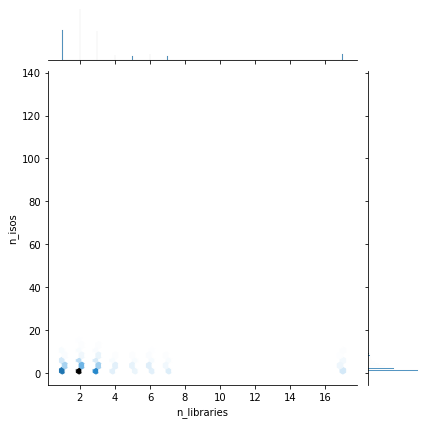

In [23]:
sns.jointplot(data=df, x='n_libraries', y='n_isos', kind='hex')

What fraction of polyA genes have >= 2 complete isoforms detected in the same sample?

In [7]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on polya genes
Number of isos reported: 98027
Found 31 total samples


In [10]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', subset='polya')
n_polya = len(gene_df.index)

df = df.loc[(df > 2).any(axis=1)]
n_det_polya = len(df.index)

print('{} / {} annotated polyA genes have >= 2 isoforms expressed in >= 1 sample'.format(n_det_polya, n_polya))

11170 / 49472 annotated polyA genes have >= 2 isoforms expressed in >= 1 sample


What fraction of TF genes have >= 2 complete isoforms detected in the same sample?

In [14]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='tf',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])

Calculating iso TPM values
Subsetting for TF genes
Enforcing minimum TPM
Total # isos detected: 109741
# isos >= 1 tpm: 100642
Subsetting on tf genes
Number of isos reported: 5479
Found 31 total samples


In [15]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', subset='tf')
n_polya = len(gene_df.index)

df = df.loc[(df > 2).any(axis=1)]
n_det_polya = len(df.index)

print('{} / {} annotated TF genes have >= 2 isoforms expressed in >= 1 sample'.format(n_det_polya, n_polya))

735 / 1419 annotated TF genes have >= 2 isoforms expressed in >= 1 sample
